In [1]:
import os
import sys
from datetime import datetime
from IPython.display import HTML

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

WIDTH = 1100
pd.options.display.float_format = 'R$ {:,.2f}'.format

caminho_commons = os.path.join('../..', '..', 'ajna_docs', 'commons')
caminho_virasana = os.path.join('../..', '..', 'ajna_docs', 'virasana')
sys.path.append(caminho_commons)
sys.path.append('../..')
sys.path.append(caminho_virasana)

from ajna_commons.flask.conf import DATABASE, MONGODB_URI

from bhadrasana.models import engine


def AnoMes(row):
    return str(row.Ano) + str(row['Mês']).zfill(2)


2024-02-19 09:49:06,934 ajna         INFO     Configuração de log efetuada


Fazendo log de erros e alertas no arquivo  ../..\..\ajna_docs\commons\ajna_commons\flask\error.log
Fazendo log de atividade no arquivo  ../..\..\ajna_docs\commons\ajna_commons\flask\access.log


# Colocar os códigos embaixo

In [108]:
def group_by_day(df, ano, mes):
    df = df[['codigoRecinto', 'dataHoraTransmissao']]
    # Filtrando os dados apenas para o ano e mês
    df_ano_mes = df[(df['dataHoraTransmissao'].dt.year == ano) & (df['dataHoraTransmissao'].dt.month == mes)]
    # Agrupando por 'CodigoRecinto' e 'dataTransmissao' e contando o número de registros
    return df_ano_mes.groupby(['codigoRecinto', df_ano_mes['dataHoraTransmissao'].dt.date]).size().reset_index(name='count')

def plot_(grouped, ano, mes):
    dias = pd.Series(grouped.dataHoraTransmissao.unique(), name='dataHoraTransmissao')
    # Para cada 'CodigoRecinto', plote um gráfico de linhas
    plt.figure(figsize=(15, 6))
    for codigo_recinto in grouped['codigoRecinto'].unique():
        data = grouped[grouped['codigoRecinto'] == codigo_recinto]
        data = data.merge(dias, how='right').fillna({'count': 0, 'codigoRecinto': codigo_recinto})
        data = data.sort_values('dataHoraTransmissao')
        ax = plt.plot(data['dataHoraTransmissao'], data['count'], label=codigo_recinto)

    # Adicionando título e legendas aos eixos
    plt.title(f'Quantidade de registros por dia - {mes}/{ano}')
    plt.xlabel('Data')
    plt.ylabel('Quantidade de registros')
    plt.legend(title='CodigoRecinto')
    plt.xticks(grouped['dataHoraTransmissao'].unique(), rotation=90)  # Rotaciona os rótulos do eixo x para melhor visualização
    return plt

def plot_linhas(df, ano, mes):
    grouped = group_by_day(df, ano, mes)
    return plot_(grouped, ano, mes)

In [3]:
SQL_ACESSOS = '''
SELECT *
FROM dbmercante.apirecintos_acessosveiculo
WHERE YEAR(dataHoraTransmissao)=2024'''

SQL_PESAGENS = '''
SELECT *
FROM dbmercante.apirecintos_pesagensveiculo
WHERE YEAR(dataHoraTransmissao)=2024'''

df_acessos = pd.read_sql(SQL_ACESSOS, engine)
df_pesagens = pd.read_sql(SQL_PESAGENS, engine)

In [4]:
df_acessos

,user_name,create_date,id,codigoRecinto,dataHoraTransmissao,dataHoraOcorrencia,tipoOperacao,contingencia,operacao,direcao,...,vazioSemirreboque,listaDeclaracaoAduaneira,tipoDeclaracao,numeroDeclaracao,listaManifestos,tipoConhecimento,numeroConhecimento,listaNfe,tipoConteiner,vazioConteiner
0,None,2024-01-10 15:57:07,1188011,8931356,2024-01-01 00:10:28,2023-12-29 04:47:38,I,0,C,S,...,0,,DI,202325450774,,CE_MERCANTE,152305328120902,,,0
1,None,2024-01-10 15:57:07,1188012,8931356,2024-01-01 00:10:30,2023-12-29 04:52:34,I,0,C,S,...,0,,DI,202325542709,,CE_MERCANTE,152305336786213,,,0
2,None,2024-01-10 15:57:07,1188013,8931356,2024-01-01 00:10:30,2023-12-29 04:53:30,I,0,C,S,...,0,,DI,202325307963,,CE_MERCANTE,152305319834434,,,0
3,None,2024-01-10 15:57:07,1188014,8931356,2024-01-01 00:10:31,2023-12-29 04:35:49,I,0,C,S,...,0,,DI,202322655979,,CE_MERCANTE,152305297901703,,,0
4,None,2024-01-10 15:57:07,1188015,8931356,2024-01-01 00:10:32,2023-12-29 04:37:50,I,0,C,S,...,0,,,,,CE_MERCANTE,152305330377150,,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275250,None,2024-02-16 11:28:54,1486706,8931318,2024-02-15 22:22:07,2024-02-15 22:18:00,I,0,C,E,...,0,,,,,,,,,0
275251,None,2024-02-16 11:28:54,1486707,8931318,2024-02-15 22:29:15,2024-02-15 22:26:00,I,0,C,S,...,0,,,,,,,,,0
275252,None,2024-02-16 11:28:54,1486708,8931318,2024-02-15 23:08:35,2024-02-15 23:03:00,I,0,C,E,...,0,,,,,CE_MERCANTE,152405039850200,,45G1,0
275253,None,2024-02-16 11:28:54,1486709,8931318,2024-02-15 23:11:36,2024-02-15 23:10:00,I,0,C,S,...,0,,,,,CE_MERCANTE,152405039850200,,45G1,0


In [5]:
df_pesagens

,user_name,create_date,id,codigoRecinto,dataHoraTransmissao,dataHoraOcorrencia,tipoOperacao,contingencia,pesoBrutoBalanca,pesoBrutoManifesto,taraConjunto,capturaAutoPeso,placa,listaConteineresUld,numeroConteiner,listaSemirreboque,placaSemirreboque,taraSemirreboque
0,None,2024-01-10 15:52:25,175416,8931318,2024-01-01 10:28:14,2024-01-01 10:26:00,I,0,"R$ 39,620.00","R$ 23,340.00",R$ 0.00,1,DBC7A14,,ESHU724054-,,DPC9304,R$ 0.00
1,None,2024-01-10 15:52:25,175417,8931318,2024-01-01 11:43:05,2024-01-01 11:38:00,I,0,"R$ 39,740.00","R$ 23,490.00",R$ 0.00,1,DBC7A14,,SEGU418416-,,DPC9304,R$ 0.00
2,None,2024-01-10 15:52:25,175418,8931318,2024-01-01 12:46:29,2024-01-01 12:43:00,I,0,"R$ 39,740.00","R$ 23,440.00",R$ 0.00,1,DBC7A14,,DFSU711959-,,DPC9304,R$ 0.00
3,None,2024-01-10 15:52:25,175419,8931318,2024-01-01 13:42:42,2024-01-01 13:41:00,I,0,"R$ 42,360.00","R$ 27,095.00",R$ 0.00,1,DBC7A14,,TEMU062591-,,DPC9304,R$ 0.00
4,None,2024-01-10 15:52:25,175420,8931318,2024-01-01 14:43:26,2024-01-01 14:41:00,I,0,"R$ 32,230.00","R$ 17,307.00",R$ 0.00,1,DBC7A14,,TEMU017987-,,DPC9304,R$ 0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41356,None,2024-02-16 11:19:16,220791,8931356,2024-02-15 23:01:27,2024-02-15 22:28:40,I,0,"R$ 44,340.00","R$ 29,700.00",R$ 0.00,1,DTC5H26,,EMCU8258175,,FEY3132,R$ 0.00
41357,None,2024-02-16 11:19:16,220792,8931356,2024-02-15 23:01:28,2024-02-15 22:30:27,I,0,"R$ 40,300.00","R$ 22,500.00",R$ 0.00,1,FVH3B53,,CMAU3036700,,ESU6198,R$ 0.00
41358,None,2024-02-16 11:19:16,220793,8931356,2024-02-15 23:01:28,2024-02-15 22:35:23,I,0,"R$ 47,180.00","R$ 31,475.00",R$ 0.00,1,GFR1J69,,TRHU4123656,,GJX9A15,R$ 0.00
41359,None,2024-02-16 11:19:16,220794,8931356,2024-02-15 23:01:28,2024-02-15 22:34:37,I,0,"R$ 24,790.00","R$ 11,670.00",R$ 0.00,1,DAJ7J60,,MRSU4776128,,CRP0617,R$ 0.00


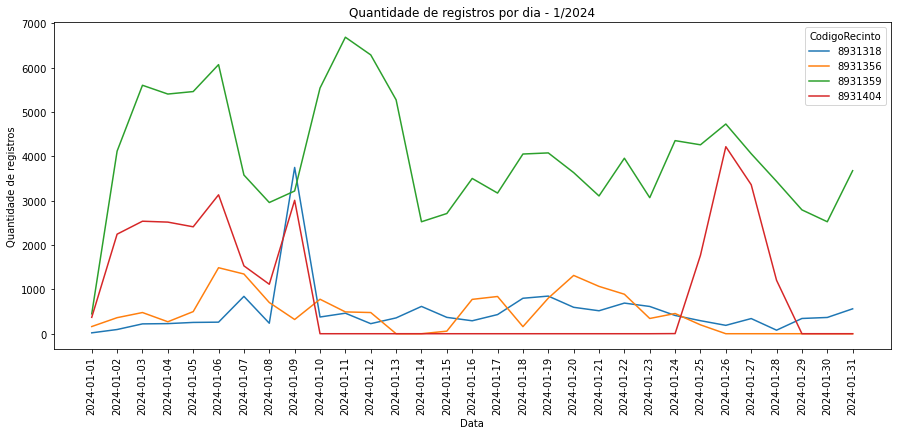

In [109]:
plot_linhas(df_acessos, 2024, 1).show()

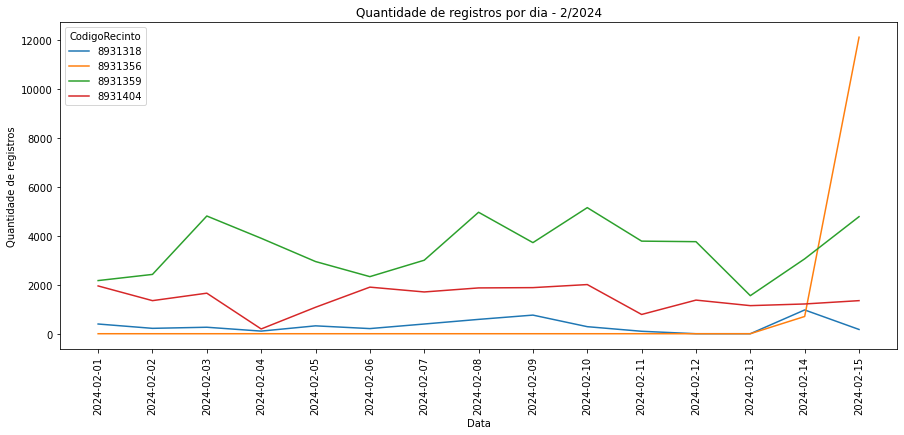

In [110]:
plot_linhas(df_acessos, 2024, 2).show()

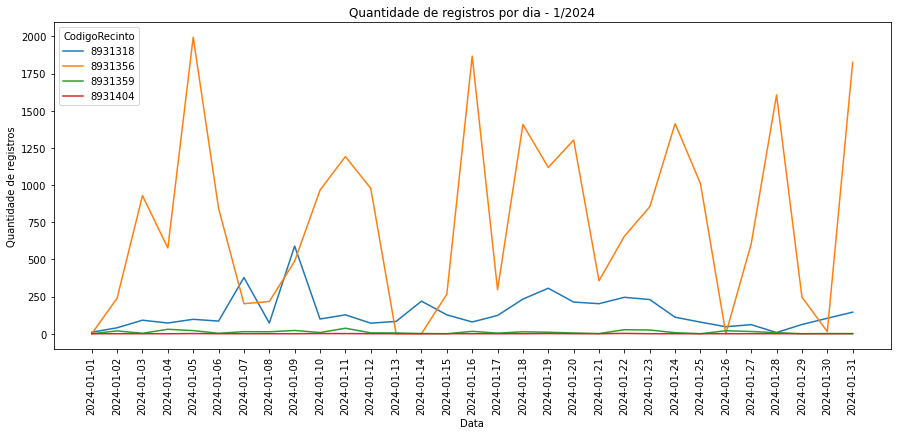

In [111]:
plot_linhas(df_pesagens, 2024, 1).show()

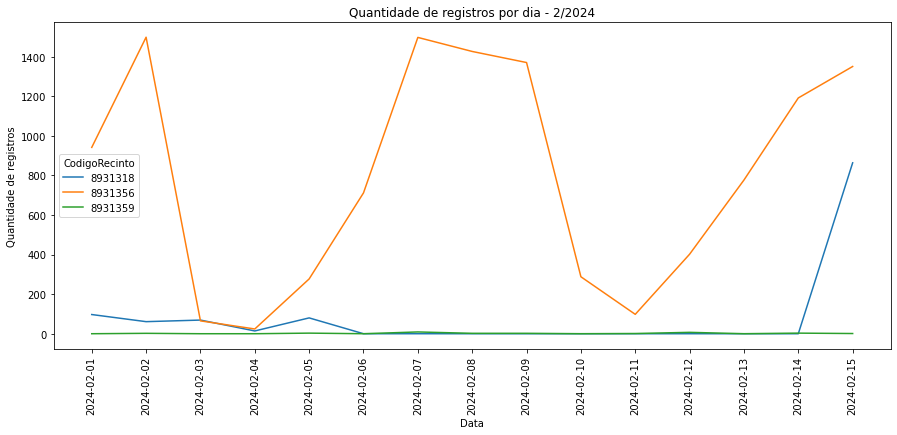

In [112]:
plot_linhas(df_pesagens, 2024, 2).show()

In [118]:
dias = pd.Series(df_acessos.dataHoraTransmissao.unique(), name='dataHoraTransmissao')
grouped_acessos = df_acessos.groupby(['codigoRecinto', df_acessos['dataHoraTransmissao'].dt.date]).size().reset_index(name='count')
grouped_pesagens = df_pesagens.groupby(['codigoRecinto', df_pesagens['dataHoraTransmissao'].dt.date]).size().reset_index(name='count')

In [119]:
grouped_eventos = grouped_acessos.merge(grouped_pesagens, how='left', on=['codigoRecinto', 'dataHoraTransmissao'])
grouped_eventos = grouped_eventos.fillna(0)
grouped_eventos['count'] = grouped_eventos['count_x'] - grouped_eventos['count_y']

In [120]:
grouped_eventos['dataHoraTransmissao'] = pd.to_datetime(grouped_eventos['dataHoraTransmissao'])

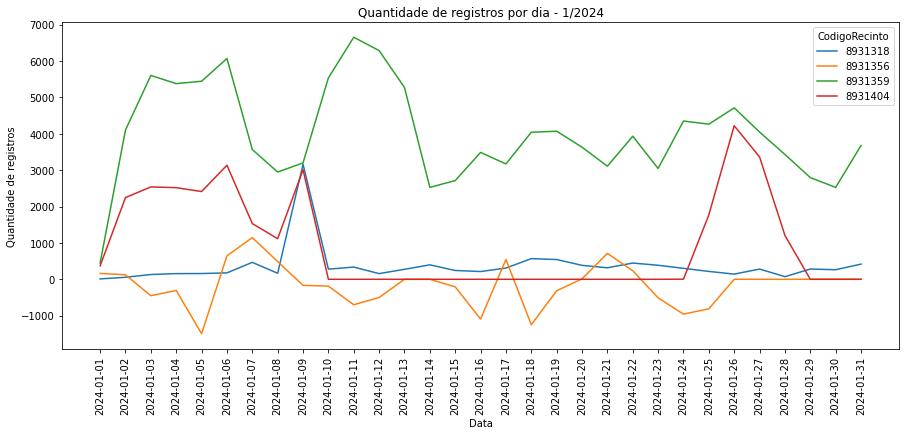

In [121]:
plot_(grouped_eventos[(grouped_eventos['dataHoraTransmissao'].dt.year == 2024) & (grouped_eventos['dataHoraTransmissao'].dt.month == 1)], 2024, 1).show()

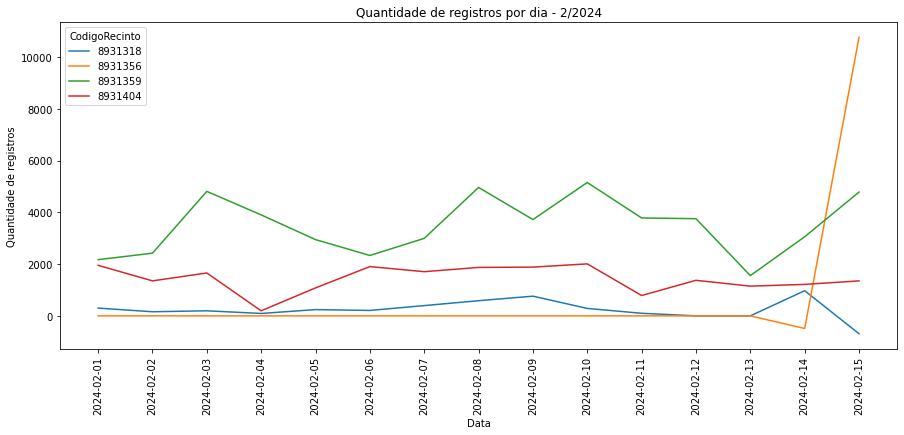

In [122]:
plot_(grouped_eventos[(grouped_eventos['dataHoraTransmissao'].dt.year == 2024) & (grouped_eventos['dataHoraTransmissao'].dt.month == 2)], 2024, 2).show()

In [87]:
import numpy as np
from datetime import timedelta
import time
def seconds_to_datetime(seconds, format='%d dias %H:%M:%S'):
    td = timedelta(seconds=seconds)
    time_obj = time.gmtime(td.total_seconds())
    return time.strftime(format, time_obj)

In [91]:
df_acessos['delay'] = (df_acessos['dataHoraTransmissao'] - df_acessos['dataHoraOcorrencia']) / np.timedelta64(1, 's')
df_acessos['mes'] = df_acessos['dataHoraTransmissao'].dt.month
print('Tirar um dia, pois dia não pode ser zero, então dia "1" na verdade é o zero')
df_acessos.groupby(['codigoRecinto', 'mes']).delay.mean().apply(lambda x: seconds_to_datetime(x))

Tirar um dia, pois dia não pode ser zero, então dia "1" na verdade é o zero


codigoRecinto  mes
8931318        1      05 dias 05:57:27
               2      02 dias 04:46:03
8931356        1      07 dias 11:36:01
               2      13 dias 13:46:27
8931359        1      01 dias 00:07:46
               2      01 dias 00:00:08
8931404        1      01 dias 12:57:16
               2      01 dias 06:26:37
Name: delay, dtype: object

In [92]:
df_pesagens['delay'] = (df_pesagens['dataHoraTransmissao'] - df_pesagens['dataHoraOcorrencia']) / np.timedelta64(1, 's')
df_pesagens['mes'] = df_pesagens['dataHoraTransmissao'].dt.month
print('Tirar um dia, pois dia não pode ser zero, então dia "1" na verdade é o zero')
df_pesagens.groupby(['codigoRecinto', 'mes']).delay.mean().apply(lambda x: seconds_to_datetime(x))

Tirar um dia, pois dia não pode ser zero, então dia "1" na verdade é o zero


codigoRecinto  mes
8931318        1      03 dias 07:04:24
               2      05 dias 15:26:41
8931356        1      01 dias 10:15:35
               2      01 dias 01:03:24
8931359        1      01 dias 03:14:55
               2      01 dias 00:00:09
8931404        1      01 dias 00:00:29
Name: delay, dtype: object